# 1. Install Dependencies 

In [ ]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib

In [ ]:
# !pip list

In [6]:
import tensorflow as tf
import os

In [4]:
# Avoid OOM (Out Of Memory) errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.config.list_physical_devices('GPU')

[]

# 2. Preprocess data

In [6]:
import cv2
import imghdr

C:\Users\DELL\AppData\Local\Temp\ipykernel_5144\4232469594.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [7]:
data_dir = 'data' 

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [16]:
import numpy as np
from matplotlib import pyplot as plt

In [11]:
tf.keras.utils

<module 'keras.api._v2.keras.utils' from 'c:\\Users\\DELL\\AppData\\Local\\Programs\\Python\\Python311\\Lib\\site-packages\\keras\\api\\_v2\\keras\\utils\\__init__.py'>

In [45]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 305 files belonging to 2 classes.


In [13]:
# tf.keras.utils.image_dataset_from_directory??

Signature:
tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
)
Source:   
@keras_export(
    "keras.utils.image_dataset_from_directory",
    "keras.preprocessing.image_dataset_from_directory",
    v1=[],
)
def image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    **kwargs,
):
    """Generates a `tf.data.Dataset` from image files in a directory.

    If your directory structure is:



In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

In [16]:
batch[0].shape

(32, 256, 256, 3)

In [17]:
batch[1]

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 0])

In [18]:
scaled = batch[0]/255
scaled.max()

1.0

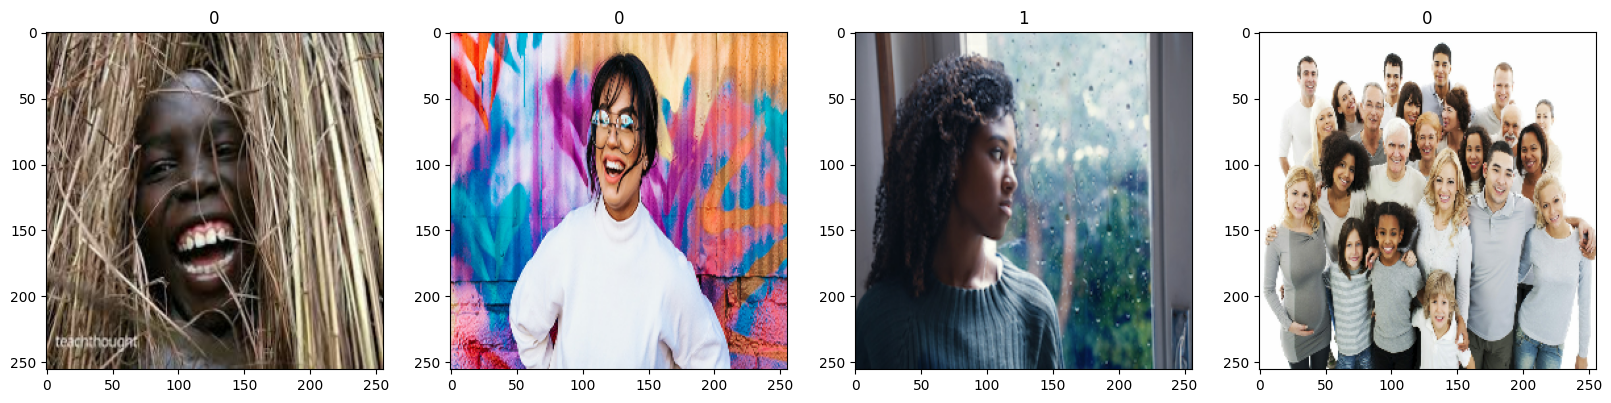

In [19]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale/Compress Data

In [46]:
data = data.map(lambda x,y: (x/255, y))

In [47]:
scaled_data = data.as_numpy_iterator().next()

In [48]:
scaled_data[0].max()

1.0

# 5. Split Data

In [49]:
len(data)

10

In [50]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [51]:
print(train_size,val_size,test_size)

7 2 1


In [52]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Building Deep Learning Model

In [53]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [55]:
model = Sequential()

In [56]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [57]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [58]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

# 7. Train

In [59]:
logdir='logs'

In [60]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [61]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 [==============================] - 8s 806ms/step - loss: 0.6876 - accuracy: 0.5223 - val_loss: 0.5464 - val_accuracy: 0.7344
Epoch 2/20
7/7 [==============================] - 7s 763ms/step - loss: 0.5358 - accuracy: 0.7902 - val_loss: 0.4863 - val_accuracy: 0.7812
Epoch 3/20
7/7 [==============================] - 6s 746ms/step - loss: 0.3859 - accuracy: 0.8304 - val_loss: 0.3914 - val_accuracy: 0.8438
Epoch 4/20
7/7 [==============================] - 6s 753ms/step - loss: 0.2798 - accuracy: 0.8929 - val_loss: 0.2257 - val_accuracy: 0.9062
Epoch 5/20
7/7 [==============================] - 7s 781ms/step - loss: 0.1980 - accuracy: 0.9598 - val_loss: 0.1645 - val_accuracy: 0.9688
Epoch 6/20
7/7 [==============================] - 7s 811ms/step - loss: 0.1409 - accuracy: 0.9732 - val_loss: 0.0998 - val_accuracy: 0.9688
Epoch 7/20
7/7 [==============================] - 6s 738ms/step - loss: 0.1057 - accuracy: 0.9732 - val_loss: 0.1101 - val_accuracy: 0.9375
Epoch 8/20
7/7 [====

# 8. Checking Performance

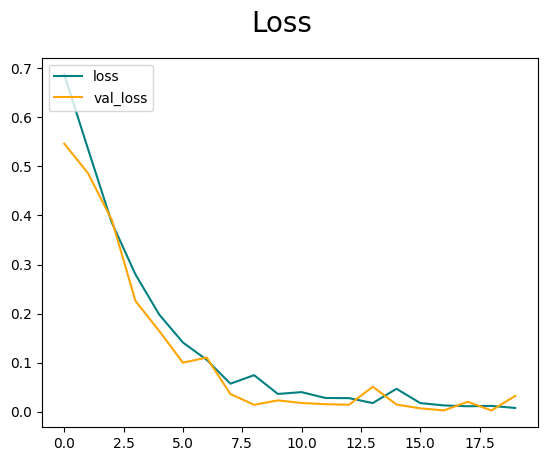

In [62]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

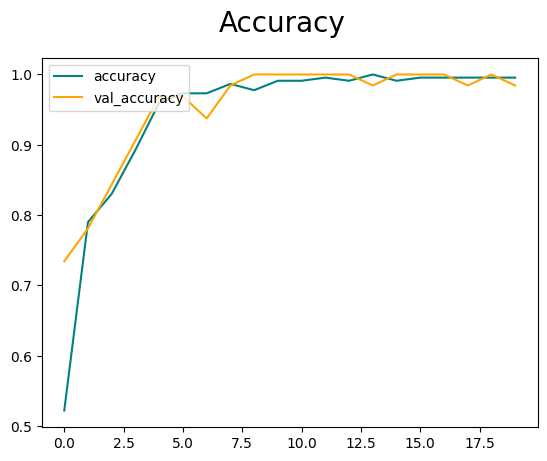

In [63]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluation

In [15]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [65]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [66]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 125ms/step


In [69]:
print(f"Presision : {pre.result().numpy()}, Recall : {re.result().numpy()}, Accuracy : {acc.result().numpy()}")

Presision : 1.0, Recall : 1.0, Accuracy : 1.0


# 10. Test

In [3]:
import cv2
from matplotlib import pyplot as plt

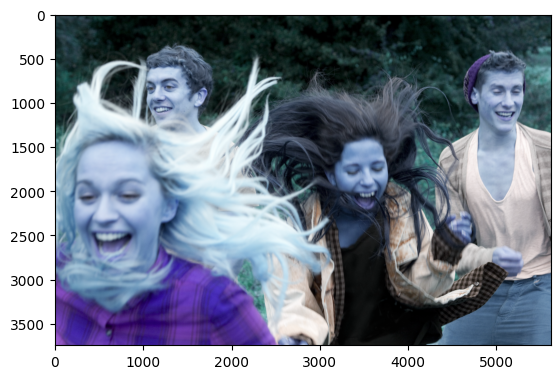

In [4]:
img = cv2.imread('154006829.jpg')
plt.imshow(img)
plt.show()

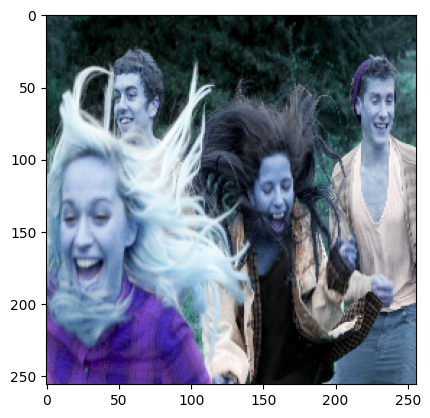

In [7]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [17]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 499ms/step


In [18]:
yhat

array([[0.0137441]], dtype=float32)

In [19]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy


# 11. Save the Model

In [8]:
from tensorflow.keras.models import load_model

In [13]:
model.save(os.path.join('models','imageclassifier.h5'))

c:\Users\DELL\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
model = load_model(os.path.join('models','imageclassifier.h5'))

In [20]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 106ms/step


In [21]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Happy
